In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This is a possible solution to Part 2 of Assignment 3.

– Chris

## Part 2: Linear Autoencoders

### (a)
> Let's start by training the model `Linear(3, 3)` on `ulu.csv` with the
> reconstruction loss objective. Initialize the weight matrix randomly (this
> is the default behavior for `Linear`) and run full-batch gradient descent
> using the raw data as input for 50 iterations. Does there exist any learning
> rate for which gradient descent has a good rate of convergence?

Training a linear model under our quadratic reconstruction loss means minimizing a function of the same form that we saw when doing least squares regression. Specifically, you can show that loss is a quadratic function of the weights and biases, and the Hessian of the loss (which is constant) depends on the mean and covariance of the data.

This is a strictly convex problem, and for sufficiently small learning rate we'll converge to the global optimum. However, our rate of converge can be very bad if the Hessian is ill-conditioned. (This is exactly the same story as when we did gradient descent for linear regression.)

Let's see what happens when we run gradient descent on this problem.

In [2]:
from iml import dl
x = pd.read_csv('data/ulu.csv').to_numpy()


def train_linear(lr, iters=50):
    np.random.seed(200)
    model = dl.Linear(3, 3, lr=lr)

    losses = []
    for _ in range(iters):
        x_hat = model(x)
        err = x_hat - x
        loss = np.power(err, 2).sum(axis=1).mean()
        losses.append(loss.item())
        model.backward(err / x.shape[0])
    return losses, model

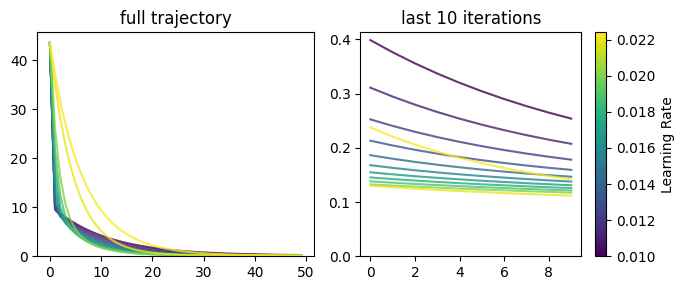

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

lrs = np.concatenate([np.linspace(0.01, 0.02, 10), [0.022, 0.0224]])
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=lrs.min(), vmax=lrs.max())

for lr in lrs:
    losses, _ = train_linear(lr)
    color = cmap(norm(lr))
    axs[0].plot(losses, color=color, alpha=0.8)
    axs[1].plot(losses[-10:], color=color, alpha=0.8)

axs[0].set_title("full trajectory")
axs[1].set_title("last 10 iterations")
axs[0].set_ylim(0, None)
axs[1].set_ylim(0, None)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs[1], label='Learning Rate')

fig.tight_layout()

Remember that loss should converge to 0, since obviously we can reconstruct our data perfectly if our linear layer is an identity map.

If you look at the whole graph it might look like convergence is happening fairly quickly, since loss drops off steeply and is relatively small by iteration 50. However, graphing the loss over the last 10 iterations tells a very different story: the improvement from one iteration to the next has become very small.

Furthermore, just by graphing the reconstruction, you can check that the loss of ~0.1 we are able to obtain with 50 iterations of gradient descent is not acceptable for this problem. A mean squared distance of 0.1 is significant relative to the scale of the data.


Loss: 0.11035110426194875


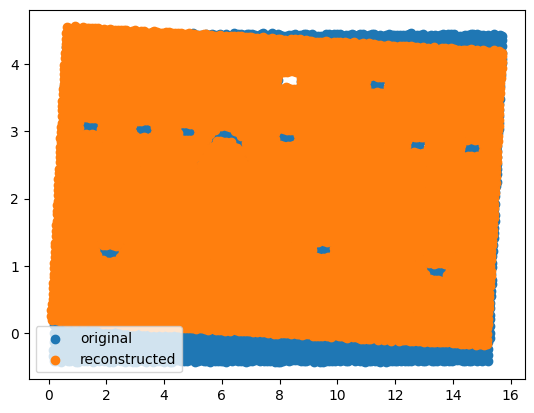

In [4]:
losses, model = train_linear(0.022)
x_hat = model(x)
print(f"Loss: {np.power(x_hat - x, 2).sum(axis=1).mean()}")

plt.scatter(x[:, 0], x[:, 1], label='original')
plt.scatter(x_hat[:, 0], x_hat[:, 1], label='reconstructed')
plt.legend()
plt.show()
# If you normalize the data before passing it into the model, it's easy to get a loss that's about 100 times smaller (~0.001) with the same number of iterations.

### (b)
> Make an autoencoder that encodes the datapoints of `ulu.csv` as
> two-dimensional vectors. Minimize its reconstruction loss (in squared
> Euclidean distance) using gradient descent. Report the final reconstruction
> loss and confirm that it is close to the theoretical minimum.

First let's compute the optimal value. We know that the optimal value is achieved by PCA; that is, the first linear layer should measure the first two principal components, and the second layer should use these two principal components to reconstruct the data.

In [5]:
x_centered = x - x.mean(axis=0, keepdims=True)
np.linalg.eigvals(x_centered.T @ x_centered / x.shape[0])

array([19.76312001,  0.16436978,  2.70810527])

The smallest eigenvalue of the data covariance matrix is about `0.16`. This is the variance of the smallest principal component of our data, and therefore the reconstruction loss of an optimal autoencoder.

We can easily optimize an autoencoder to reach this loss if we normalize the data before passing it to the input layer. (Note that it is _not_ acceptable to normalize the data used to compute the reconstruction loss, because this changes the problem we're trying to solve!)

In [6]:
from tqdm import tqdm

def train_autoencoder(lr, iters=200):
    np.random.seed(100)
    model = dl.Sequential(
        dl.Scaler.fit(x),
        dl.Linear(3, 2, lr=lr),
        dl.Linear(2, 3, lr=lr),
    )
    losses = []
    for _ in range(iters):
        x_hat = model(x)
        err = x_hat - x
        loss = np.power(err, 2).sum(axis=1).mean()
        losses.append(loss.item())
        model.backward(err / x.shape[0])
    return losses, model

losses, model = train_autoencoder(0.1)
losses[-1]

0.1646352902805189

### (c)
> Implement a `DropoutOne` module whose forward pass zeros out the first
> dimension of each input vector with independent probability $0.5.$ What is
> the correct way to implement a backwards pass for this module?

In [7]:
class DropoutOne(dl.Module):
    def forward(self, x):
        x_out = x.copy()
        self.mask = np.random.random(x.shape[0]) > 0.5
        x_out[:, 0] *= self.mask
        return x_out

    def backward(self, gy):
        gy_out = gy.copy()
        gy_out[:, 0] *= self.mask
        return gy_out

The backwards pass of a module is intended to compute a gradient with respect to the module's input parameters given a gradient with respect to its output parameters.

The subtlety in this question is that is introduces a third kind of variable, which strictly speaking is neither input nor output: namely, the choice of what indices to drop from the input. To implement `DropoutOne` we treat this variable as an input whose gradient we don't need to compute.

### (d)
> By incorporating `DropoutOne` into the forward pass, train an autoencoder in
> such a way that the first dimension of the code reliably distinguishes the
> foreground and background parts of `ulu.csv`. Ensure that your model
> converges approximately within 500 iterations of full-batch gradient descent
> and log its reconstruction loss. How can you determine the optimal expected
> reconstruction loss for this model?

Remember that the `ulu.csv` dataset is generated by taking the ulu logo, sampling the spatial domain, creating datapoints with attributes `(x, y, color)`, and then taking a linear transformation.

Because of the way these three attributes are scaled, the foreground and background of the image are distinguished by the value of the principal component with _smallest_ variance.

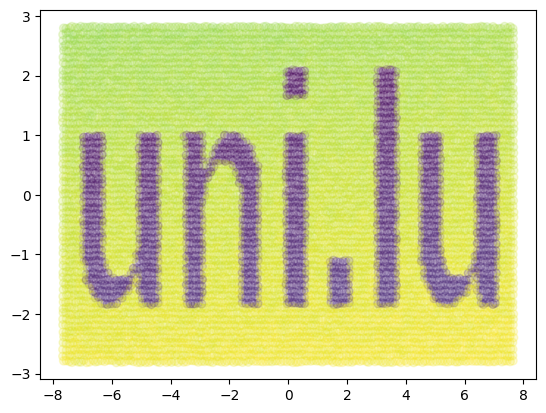

In [8]:
from sklearn.decomposition import PCA

transformed = PCA(n_components=3).fit_transform(x)
plt.scatter(transformed[:, 0], transformed[:, 1], c=transformed[:, 2], alpha=0.2)
plt.show()

What happens if we train a linear autoencoder with $k$ latent dimensions and apply dropout to the first latent?

In this case, reconstruction loss is minimized by a model that stores the top $k - 1$ principal components of the data in the last $k - 1$ latents and stores the $k$th component in the first latent. (I wrote something about this problem in the class notes here https://cgad.ski/notes/class-on-10-12-2025.html#loss-of-a-linear-autoencoder-with-dropout).

Let's see what this looks like.

In [9]:
def train_dropout(lr, iters=500, n_latent=3):
    vars = PCA(n_components=3).fit(x).explained_variance_
    ideal = 0.5 * vars[n_latent:].sum() + 0.5 * vars[n_latent - 1:].sum()
    # ideal loss is the average between the loss we would get with n_latent
    # and the loss we would get with n_latent - 1

    np.random.seed(100)
    model = dl.Sequential(
        dl.Scaler.fit(x),
        dl.Linear(3, n_latent, lr=lr),
        DropoutOne(),
        dl.Linear(n_latent, 3, lr=lr),
    )
    losses = []
    for _ in range(iters):
        x_hat = model(x)
        err = x_hat - x
        loss = np.power(err, 2).sum(axis=1).mean()
        losses.append(loss.item())
        model.backward(err / x.shape[0])

    print(f"Ideal loss: {ideal}")
    print(f"Actual loss obtained: {losses[-1]}")

    return losses, model

def show_latent(latent):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    axs[0].scatter(transformed[:, 0], transformed[:, 1], c=latent, alpha=0.2)
    axs[1].hist(latent)
    fig.tight_layout()
    plt.show()

Ideal loss: 1.518595418210467
Actual loss obtained: 1.5325977206142816


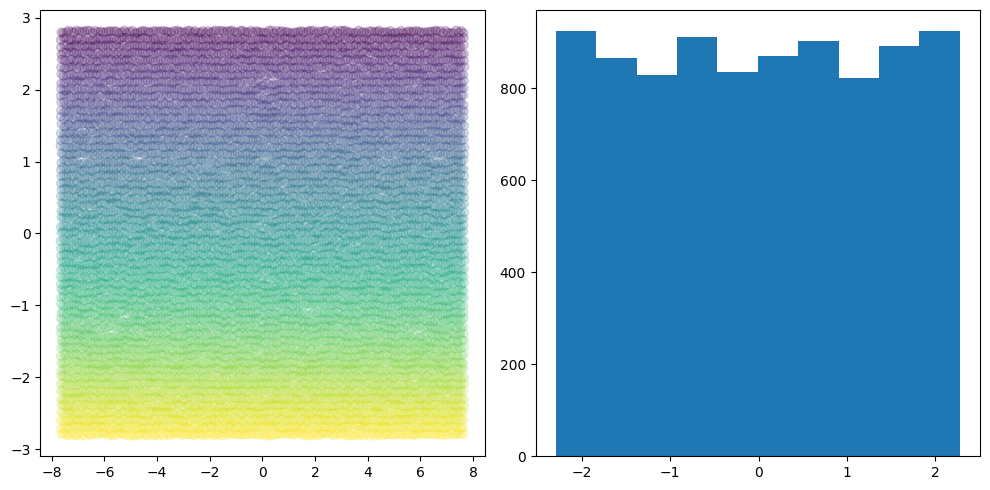

In [10]:
# When we use two latent dimensions, the first will learn the second principal component of the data, which in the case of our dataset is the y axis of the original image.
losses, model = train_dropout(0.09, n_latent=2)
latent = dl.Sequential(*model.components[:2])(x)[:, 0]
show_latent(latent)

Ideal loss: 0.08219425480952618
Actual loss obtained: 0.0853980714321819


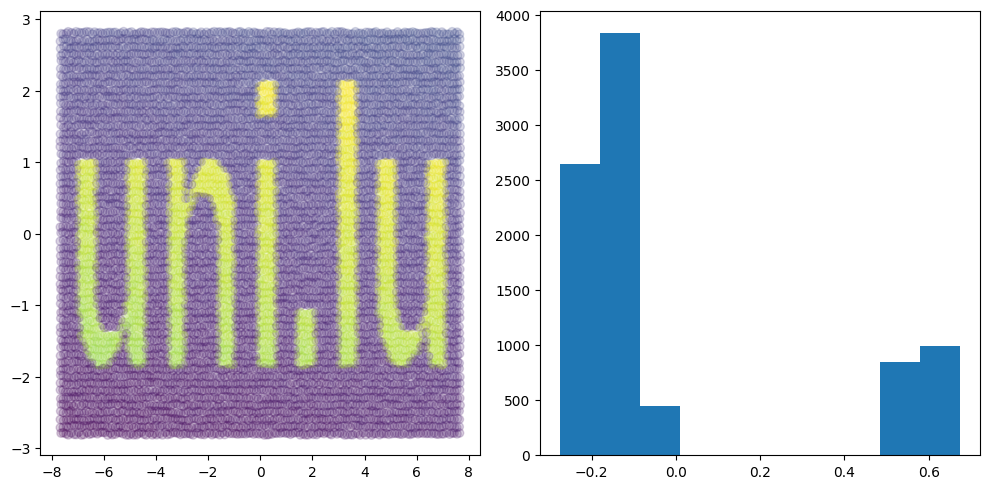

In [11]:
# When we use three latent dimensions, the first learns the third principal component.
losses, model = train_dropout(0.09, n_latent=3)
latent = dl.Sequential(*model.components[:2])(x)[:, 0]
show_latent(latent)